In [1]:
import mss
import subprocess
import keyboard
import os.path
import time
import math
import numpy as np
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [43]:
class boardReaderIM:
    coords = [0,0,0,0]
    width, height = 0,0
    counter = 1
    def getFigs(self):
        with mss.mss() as sct:
            monitor = {"top": min(self.coords[1],self.coords[3]), 
                       "left": min(self.coords[0],self.coords[2]),
                       "width": self.width, "height": self.height,
                       "mon": 1,}
            sct_img = sct.grab(monitor)
            pix_array = np.array(Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX"))
            pix_array = np.array(resize(pix_array,(224,224),anti_aliasing=True, mode='reflect'));
            imgplot = plt.imshow(pix_array)
            plt.show()
            
            figs = np.zeros((64,28,28,3))
            k = 0
            for i in range(0,8): 
                for j in range(0,8):
                    figs[k] = pix_array[i*28:(i+1)*28,j*28:(j+1)*28,0:3]*255.0
                    k+=1
                    
            return figs
    
    def writeToDataset(self,figs):
        #black rook
        im = Image.fromarray(figs[0].astype('uint8'))
        im.save("dataset/rook_black{}.png".format(self.counter))
        #black knight
        im = Image.fromarray(figs[1].astype('uint8'))
        im.save("dataset/knight_black{}.png".format(self.counter))
        #black bishop
        im = Image.fromarray(figs[2].astype('uint8'))
        im.save("dataset/bishop_black{}.png".format(self.counter))
        #black queen
        im = Image.fromarray(figs[3].astype('uint8'))
        im.save("dataset/queen_black{}.png".format(self.counter))
        #black king
        im = Image.fromarray(figs[4].astype('uint8'))
        im.save("dataset/king_black{}.png".format(self.counter))
        #black pawn
        im = Image.fromarray(figs[9].astype('uint8'))
        im.save("dataset/pawn_black{}.png".format(self.counter))
        #empty
        im = Image.fromarray(figs[17].astype('uint8'))
        im.save("dataset/empty_white{}.png".format(self.counter))
        #empty
        im = Image.fromarray(figs[18].astype('uint8'))
        im.save("dataset/empty_black{}.png".format(self.counter))
        #black rook
        im = Image.fromarray(figs[48].astype('uint8'))
        im.save("dataset/pawn_white{}.png".format(self.counter))
        #black knight
        im = Image.fromarray(figs[56].astype('uint8'))
        im.save("dataset/rook_white{}.png".format(self.counter))
        #black bishop
        im = Image.fromarray(figs[57].astype('uint8'))
        im.save("dataset/knight_white{}.png".format(self.counter))
        #black queen
        im = Image.fromarray(figs[58].astype('uint8'))
        im.save("dataset/bishop_white{}.png".format(self.counter))
        #black king
        im = Image.fromarray(figs[59].astype('uint8'))
        im.save("dataset/queen_white{}.png".format(self.counter))
        #black pawn
        im = Image.fromarray(figs[60].astype('uint8'))
        im.save("dataset/king_white{}.png".format(self.counter))
        self.counter+=1
    
    def getScreenshot(self):
        mss.mss().shot(mon=1, output='images/screenshot.png')
    
    def getNewBoard(self):    
        self.getScreenshot()
        line = subprocess.check_output(['Scripts/SelectArea.exe','images/screenshot.png']).decode("utf-8")
        line = line[:-2]
        line = line.split(' ')
        for i in range(0,4):self.coords[i] = int(line[i])
        
        if(self.coords[0] > self.coords[2]):self.coords[0],self.coords[2] = self.coords[2],self.coords[0]
        if(self.coords[1] > self.coords[3]):self.coords[1],self.coords[3] = self.coords[3],self.coords[1]

        self.width = abs(self.coords[0] - self.coords[2])
        self.height = abs(self.coords[1] - self.coords[3])
        time.sleep(0.300)
        figs = self.getFigs()
        self.writeToDataset(figs)

In [ ]:
class boardReaderCSV:
    coords = [0,0,0,0]
    width, height = 0,0
    
    def getFigs(self):
        with mss.mss() as sct:
            monitor = {"top": min(self.coords[1],self.coords[3]), 
                       "left": min(self.coords[0],self.coords[2]),
                       "width": self.width, "height": self.height,
                       "mon": 1,}
            sct_img = sct.grab(monitor)
            pix_array =  np.array([list(a) for a in zip(sct_img.raw[2::4], sct_img.raw[1::4], sct_img.raw[0::4])])
            pix_array = np.dot(pix_array[...,:3], [0.3, 0.59, 0.11]);
            pix_array = pix_array.reshape(self.height,self.width)
            
            if(self.width < self.height):
                pix_array = np.pad(pix_array,((0,0),(int((self.height-self.width)/2),int((self.height-self.width)/2))),'edge')
            elif(self.width > self.height):
                pix_array = np.pad(pix_array,((int((self.width-self.height)/2),int((self.width-self.height)/2)),(0,0)),'edge')
            
            pix_array = resize(pix_array,(224,224),anti_aliasing=True, mode='reflect', preserve_range=True);
            
            imgplot = plt.imshow(pix_array)
            plt.show()
            
            figs = np.zeros((64,28,28))
            k = 0
            for i in range(0,8): 
                for j in range(0,8):
                    figs[k] = pix_array[i*28:(i+1)*28,j*28:(j+1)*28]
                    k+=1
            figs.resize(64,784)
            return figs
    
    def writeToCSV(self,figs):
        print(figs.shape)
        if(not os.path.isfile('dataGray28.csv')):
            f = open('dataGray28.csv','w+')
            for i in range(1,29):
                for j in range(1,29):
                    f.write('{}x{},'.format(i,j));
            f.write('type,color\n')
            f.close()
        f = open('dataGray28.csv','a')
        #black rook
        for a in figs[0]:f.write('{},'.format(a))
        f.write('rook,black\n');
        #black knight
        for a in figs[1]:f.write('{},'.format(a))
        f.write('knight,black\n');
        #black bishop
        for a in figs[2]:f.write('{},'.format(a))
        f.write('bishop,black\n');
        #black queen
        for a in figs[3]:f.write('{},'.format(a))
        f.write('queen,black\n');
        #black king
        for a in figs[4]:f.write('{},'.format(a))
        f.write('king,black\n');
        #black pawn
        for a in figs[9]:f.write('{},'.format(a))
        f.write('pawn,black\n');
        #empty
        for a in figs[17]:f.write('{},'.format(a))
        f.write('empty,white\n');
        #empty
        for a in figs[18]:f.write('{},'.format(a))
        f.write('empty,white\n');
        #black rook
        for a in figs[48]:f.write('{},'.format(a))
        f.write('pawn,white\n');
        #black knight
        for a in figs[56]:f.write('{},'.format(a))
        f.write('rook,white\n');
        #black bishop
        for a in figs[57]:f.write('{},'.format(a))
        f.write('knight,white\n');
        #black queen
        for a in figs[58]:f.write('{},'.format(a))
        f.write('bishop,white\n');
        #black king
        for a in figs[59]:f.write('{},'.format(a))
        f.write('queen,white\n');
        #black pawn
        for a in figs[60]:f.write('{},'.format(a))
        f.write('king,white\n');
        f.close()
    
    def getScreenshot(self):
        mss.mss().shot(mon=1, output='images/screenshot.png')
    
    def getNewBoard(self):    
        self.getScreenshot()
        line = subprocess.check_output(['Scripts/SelectArea.exe','images/screenshot.png']).decode("utf-8")
        line = line[:-2]
        line = line.split(' ')
        for i in range(0,4):self.coords[i] = int(line[i])
        
        if(self.coords[0] > self.coords[2]):self.coords[0],self.coords[2] = self.coords[2],self.coords[0]
        if(self.coords[1] > self.coords[3]):self.coords[1],self.coords[3] = self.coords[3],self.coords[1]

        self.width = abs(self.coords[0] - self.coords[2])
        self.height = abs(self.coords[1] - self.coords[3])
        time.sleep(0.300)
        figs = self.getFigs()
        self.writeToCSV(figs)

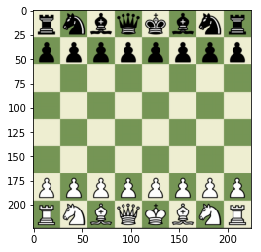

In [42]:
br = boardReaderCSV()
mode = 'csv'
while(1):
    if(keyboard.is_pressed('shift+i')):
        mode = 'im'
        br = boardReaderIM()
        break
    if(keyboard.is_pressed('shift+t')):
        mode = 'csv'
        break
    if(keyboard.is_pressed('shift+q')):
        exit()
while(1):
    if(keyboard.is_pressed('shift+n')):
        br.getNewBoard()
    if(keyboard.is_pressed('shift+q')):
        break
    if(keyboard.is_pressed('shift+d+e')):
        os.remove('dataGray28.csv')